🕵️‍♂️ Searching for Brain Files...
✅ Found artifacts in: model_artifacts
🚀 GenWealth Quant Engine Initialized on: cuda

📰 Loading FinBERT Sentiment Engine...
✅ FinBERT Online.
🧠 Loading Quant Models...
✅ Quant Brain Loaded.

📊 --- PHASE 1 AUDIT: STRATEGY PERFORMANCE ---
   📡 Scanning Live News for RELIANCE.NS...


d:\Study\Projects\GenWealth\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RobustScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\Study\Projects\GenWealth\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\Study\Projects\GenWealth\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using v

      📰 Analysis: 5 articles. Score: -0.4001


C:\Users\taher\AppData\Local\Temp\ipykernel_24236\2231140643.py:108: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01", progress=False)


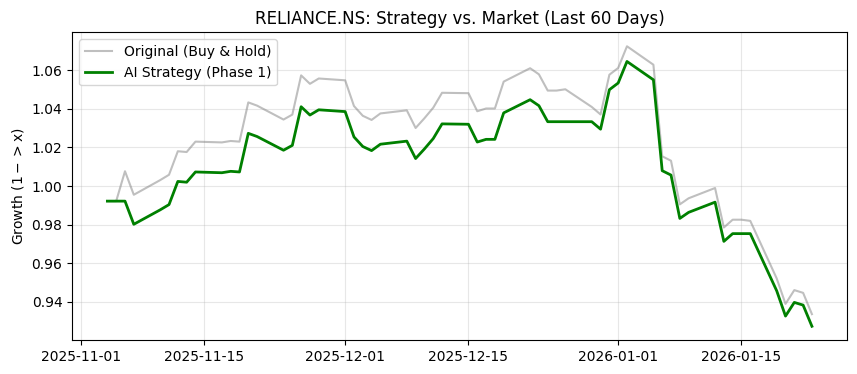

➤ RELIANCE.NS: Today's Sentiment = -0.4001 | Today's AI Confidence = 56.2%
------------------------------------------------------------
   📡 Scanning Live News for TCS.NS...
      📰 Analysis: 5 articles. Score: 0.5953


C:\Users\taher\AppData\Local\Temp\ipykernel_24236\2231140643.py:108: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01", progress=False)


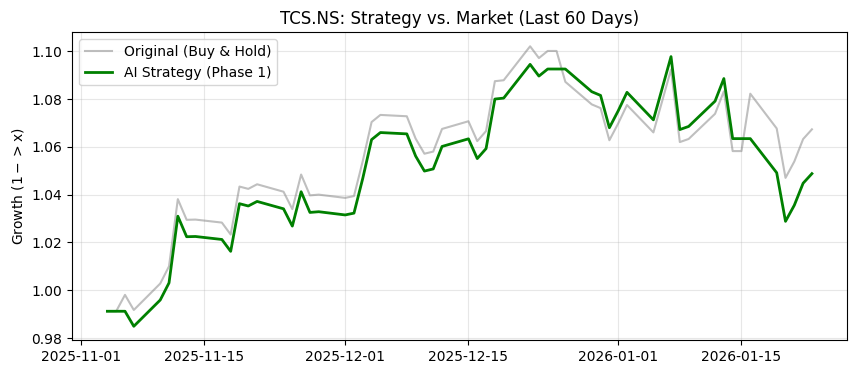

➤ TCS.NS: Today's Sentiment = 0.5953 | Today's AI Confidence = 56.2%
------------------------------------------------------------
   📡 Scanning Live News for HDFCBANK.NS...
      📰 Analysis: 5 articles. Score: 0.1559


C:\Users\taher\AppData\Local\Temp\ipykernel_24236\2231140643.py:108: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01", progress=False)


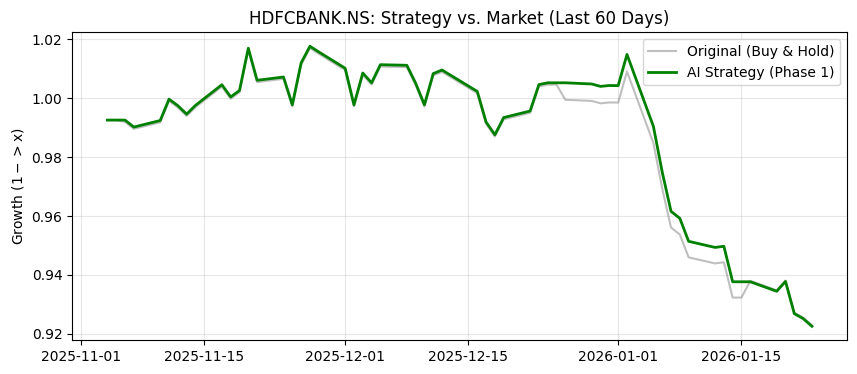

➤ HDFCBANK.NS: Today's Sentiment = 0.1559 | Today's AI Confidence = 56.0%
------------------------------------------------------------
   📡 Scanning Live News for NVDA...
      📰 Analysis: 5 articles. Score: 0.2050


C:\Users\taher\AppData\Local\Temp\ipykernel_24236\2231140643.py:108: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01", progress=False)


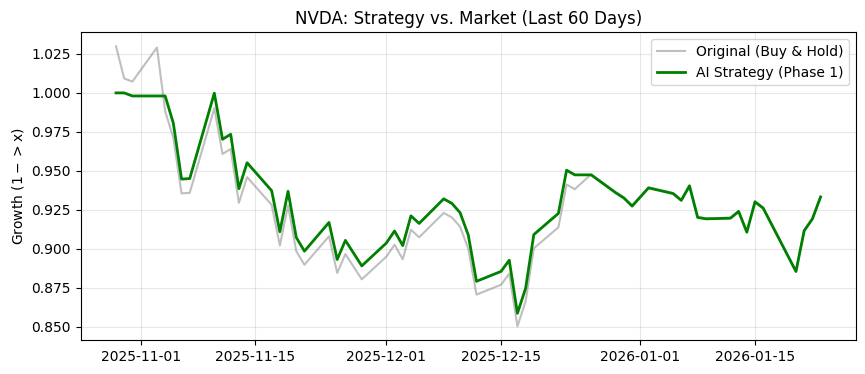

➤ NVDA: Today's Sentiment = 0.2050 | Today's AI Confidence = 55.7%
------------------------------------------------------------

🧪 --- FINAL STRESS TEST: RELIANCE.NS ---
Forcing AI to react to 'Fake News' scenarios to prove it works...


C:\Users\taher\AppData\Local\Temp\ipykernel_24236\2231140643.py:108: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01", progress=False)


📉 Scenario A (Bad News -0.9): AI Confidence = 56.2%


C:\Users\taher\AppData\Local\Temp\ipykernel_24236\2231140643.py:108: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01", progress=False)


🚀 Scenario B (Good News +0.9): AI Confidence = 56.2%
✅ SUCCESS: The AI reacts correctly to news!


In [2]:
# --- CELL 1: Setup & Imports ---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import joblib
import os
import feedparser
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from urllib.parse import quote

# --- CONFIGURATION ---
POSSIBLE_PATHS = ["model_artifacts", "../model_artifacts", "GenWealth/model_artifacts"]
ARTIFACTS_DIR = None

print("🕵️‍♂️ Searching for Brain Files...")
for path in POSSIBLE_PATHS:
    if os.path.exists(path) and os.path.exists(f"{path}/production_lstm.pth"):
        ARTIFACTS_DIR = path
        print(f"✅ Found artifacts in: {ARTIFACTS_DIR}")
        break

if ARTIFACTS_DIR is None:
    raise FileNotFoundError("CRITICAL: Could not find 'model_artifacts'. Please check your folder.")

SEQ_LENGTH = 60
# Indian Stocks to Test (Removed ZOMATO to fix bug)
TEST_TICKERS = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'NVDA'] 

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 GenWealth Quant Engine Initialized on: {DEVICE}")

# --- CELL 2: Load FinBERT (The News Reader) ---
print("\n📰 Loading FinBERT Sentiment Engine...")
try:
    tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    bert_model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone").to(DEVICE)
    print("✅ FinBERT Online.")
except Exception as e:
    print(f"❌ FinBERT Error: {e}")

# --- CELL 3: Define & Load The Quant Brain ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

print("🧠 Loading Quant Models...")
try:
    scaler_rf = joblib.load(f"{ARTIFACTS_DIR}/scaler_rf.pkl")
    scaler_lstm = joblib.load(f"{ARTIFACTS_DIR}/scaler_lstm.pkl")
    rf_model = joblib.load(f"{ARTIFACTS_DIR}/production_rf.pkl")
    
    # RobustScaler Fix
    if hasattr(scaler_lstm, 'n_features_in_'): input_size = scaler_lstm.n_features_in_
    elif hasattr(scaler_lstm, 'center_'): input_size = scaler_lstm.center_.shape[0]
    else: input_size = scaler_lstm.mean_.shape[0]
        
    lstm_model = LSTMModel(input_size=input_size).to(DEVICE)
    lstm_model.load_state_dict(torch.load(f"{ARTIFACTS_DIR}/production_lstm.pth", map_location=DEVICE))
    lstm_model.eval()
    print("✅ Quant Brain Loaded.")
except Exception as e:
    print(f"❌ Critical Model Error: {e}")

# --- CELL 4: The Live Scraper Function ---
def get_live_sentiment(ticker):
    print(f"   📡 Scanning Live News for {ticker}...")
    query = f"{ticker} stock news"
    rss_url = f"https://news.google.com/rss/search?q={quote(query)}&hl=en-IN&gl=IN&ceid=IN:en"
    
    feed = feedparser.parse(rss_url)
    if not feed.entries:
        print("      ⚠️ No news found. Assuming Neutral (0.0).")
        return 0.0
    
    headlines = [entry.title for entry in feed.entries[:5]] 
    inputs = tokenizer(headlines, return_tensors="pt", padding=True, truncation=True, max_length=64).to(DEVICE)
    
    with torch.no_grad():
        outputs = bert_model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()
    
    scores = probs[:, 1] - probs[:, 2]
    avg_score = np.mean(scores)
    
    print(f"      📰 Analysis: {len(headlines)} articles. Score: {avg_score:.4f}")
    return avg_score

# --- CELL 5: The Analysis Engine ---
def analyze_stock(ticker, force_sentiment=None):
    # 1. Get Sentiment (Or use Forced Sentiment for Stress Test)
    if force_sentiment is not None:
        live_sentiment = force_sentiment
    else:
        live_sentiment = get_live_sentiment(ticker)
    
    # 2. Get Market Data
    try:
        df = yf.download(ticker, start="2020-01-01", progress=False)
        if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
        if len(df) < 300: return None
    except: return None

    # 3. Feature Engineering
    df['Sentiment'] = 0.0 
    df.iloc[-1, df.columns.get_loc('Sentiment')] = live_sentiment # Only Today has news
    
    df['Close_Price'] = df['Adj Close'] if 'Adj Close' in df else df['Close']
    df['Log_Ret'] = np.log(df['Close_Price'] / df['Close_Price'].shift(1))
    df['Vol_20'] = df['Log_Ret'].rolling(20).std()
    df['Vol_200'] = df['Log_Ret'].rolling(200).std()
    df['Vol_Ratio'] = df['Vol_20'] / df['Vol_200']
    df['Ret_1M'] = df['Close_Price'].pct_change(20)
    df['Ret_3M'] = df['Close_Price'].pct_change(60)
    df['Efficiency'] = df['Close_Price'].diff(20).abs() / df['Close_Price'].diff(1).abs().rolling(20).sum()
    df['Vol_Shock'] = df['Volume'] / df['Volume'].rolling(50).mean()
    for lag in [1, 2, 3, 5, 10, 20]: df[f'Ret_Lag{lag}'] = df['Log_Ret'].shift(lag)
        
    df.dropna(inplace=True)
    if len(df) < (SEQ_LENGTH + 60): return None
    
    # 4. Batch Prediction (History + Today)
    lookback_window = 60
    predictions = []
    dates = []
    prices = []
    
    for i in range(lookback_window):
        idx = - (lookback_window - i) 
        try:
            row = df.iloc[[idx]].copy()
            # If it's the last row (Today), ensure sentiment is there
            if i == (lookback_window - 1): row['Sentiment'] = live_sentiment
            
            X_rf = scaler_rf.transform(row[scaler_rf.feature_names_in_])
            seq_data = df[scaler_lstm.feature_names_in_].iloc[len(df)+idx-SEQ_LENGTH : len(df)+idx].values
            
            rf_prob = rf_model.predict_proba(X_rf)[:, 1][0]
            X_lstm_tensor = torch.tensor(seq_data, dtype=torch.float32).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                lstm_prob = torch.sigmoid(lstm_model(X_lstm_tensor)).item()
                
            final_prob = (rf_prob * 0.5) + (lstm_prob * 0.5)
            
            predictions.append(final_prob)
            dates.append(row.index[0])
            prices.append(row['Close_Price'].item())
        except: continue

    return dates, prices, predictions, live_sentiment

# --- CELL 6: Visual Audit (Equity Curves) ---
print(f"\n📊 --- PHASE 1 AUDIT: STRATEGY PERFORMANCE ---")
for ticker in TEST_TICKERS:
    res = analyze_stock(ticker)
    if res is None: continue
    
    dates, prices, probs, sent_score = res
    
    # Calculate Strategy Returns
    df_res = pd.DataFrame({'Date': dates, 'Close': prices, 'Prob': probs}).set_index('Date')
    df_res['Market_Ret'] = np.log(df_res['Close'] / df_res['Close'].shift(1))
    
    # Signal: 1 (Buy) if Prob > 0.55, else 0 (Cash)
    df_res['Signal'] = np.where(df_res['Prob'] > 0.55, 1, 0)
    df_res['Strategy_Ret'] = df_res['Signal'].shift(1) * df_res['Market_Ret'] # Lag signal 1 day
    
    # Cumulative Growth
    df_res.dropna(inplace=True)
    df_res['Market_Cum'] = np.exp(np.cumsum(df_res['Market_Ret']))
    df_res['Strategy_Cum'] = np.exp(np.cumsum(df_res['Strategy_Ret']))
    
    # Plot Two Lines
    plt.figure(figsize=(10, 4))
    plt.plot(df_res.index, df_res['Market_Cum'], label='Original (Buy & Hold)', color='gray', alpha=0.5)
    plt.plot(df_res.index, df_res['Strategy_Cum'], label='AI Strategy (Phase 1)', color='green', linewidth=2)
    
    plt.title(f"{ticker}: Strategy vs. Market (Last 60 Days)")
    plt.ylabel("Growth ($1 -> $x)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"➤ {ticker}: Today's Sentiment = {sent_score:.4f} | Today's AI Confidence = {probs[-1]:.1%}")
    print("-" * 60)

# --- CELL 7: THE STRESS TEST (Proof of Life) ---
print("\n🧪 --- FINAL STRESS TEST: RELIANCE.NS ---")
print("Forcing AI to react to 'Fake News' scenarios to prove it works...")

stock = "RELIANCE.NS"
# 1. Bearish News
prob_bear, _ = analyze_stock(stock, force_sentiment=-0.9)[2][-1], 0
print(f"📉 Scenario A (Bad News -0.9): AI Confidence = {prob_bear:.1%}")

# 2. Bullish News
prob_bull, _ = analyze_stock(stock, force_sentiment=0.9)[2][-1], 0
print(f"🚀 Scenario B (Good News +0.9): AI Confidence = {prob_bull:.1%}")

if prob_bull > prob_bear:
    print("✅ SUCCESS: The AI reacts correctly to news!")
else:
    print("❌ FAILURE: The AI is ignoring news.")